In [1]:
%run '/home/gvolta/XENONnT/LedAnalysis/Initialization_for_SPE.py'

0.0.8
               option          default    current          applies_to  \
0          LED_window       (125, 250)  <OMITTED>  (led_calibration,)   
1        noise_window       (350, 475)  <OMITTED>  (led_calibration,)   
2         light_level         (0, 248)  <OMITTED>  (led_calibration,)   
3         pax_raw_dir  /data/xenon/raw  <OMITTED>      (raw_records,)   
4     stop_after_zips                0  <OMITTED>      (raw_records,)   
5    events_per_chunk               50  <OMITTED>      (raw_records,)   
6  samples_per_record              110  <OMITTED>      (raw_records,)   

                                                help  
0  Window (samples) where we expect the signal in...  
1             Window (samples) to analysis the noise  
2  Three different light level for XENON1T: (0,36...  
3                    Directory with raw pax datasets  
4         Convert only this many zip files. 0 = all.  
5                Number of events to yield per chunk  
6                       

In [2]:
run_id = '180219_1049'
data_rr = st.get_array(run_id, 'raw_records', seconds_range=(0,20))

In [3]:
datatype = [('pmt', np.int16),
            ('Amplitude', np.float32),
            ('Sample of Amplitude', np.float32)]

Data = np.zeros((len(data_rr)), dtype = datatype)

for i in range(len(data_rr)):
    Data[i]['pmt'] = data_rr['channel'][i]
    Data[i]['Amplitude'] = np.max(data_rr['data'][i])
    Data[i]['Sample of Amplitude'] = np.argmax(data_rr['data'][i])

Text(0.5, 0, 'amp (ADC counts)')

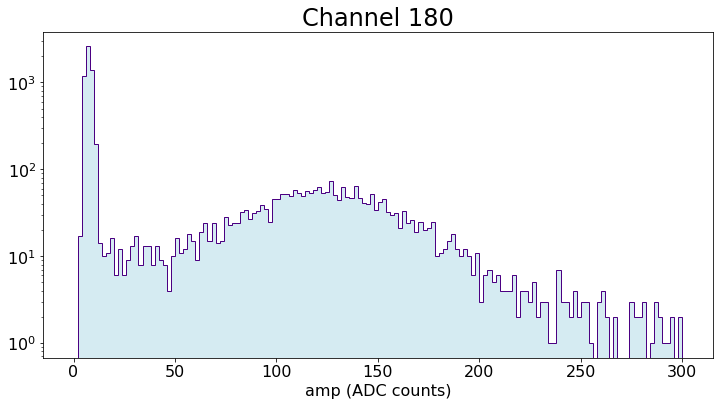

In [10]:
plt.figure(figsize=(12,6))
n_channel = 180

plt.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='bar', color='lightblue', alpha=0.5)
plt.hist(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300), histtype='step', color='indigo')
plt.yscale('log')
plt.title('Channel %d' %n_channel)
plt.xlabel('amp (ADC counts)')

In [130]:
def Noise(x, A0, mu0, sgm0):
    Noise = A0 * np.exp(-((x-mu0)**2)/2*sgm0**2)
    return Noise
def SPE(x, A1, lamb, mu1, sgm1):
    SPE = A1 * ((lamb**1)*(np.exp(-lamb))/1) * np.exp(-((x-mu1)**2)/(2*(1*sgm1)**2))
    return SPE
def DPE(x, A1, lamb, mu1, sgm1):
    SPE = A1 * ((lamb**1)*(np.exp(-lamb))/1) * np.exp(-((x-(mu1))**2)/(2*(1*sgm1)**2))
    DPE = A1 * ((lamb**1)*(np.exp(-lamb))/1) * np.exp(-((x-(2*mu1))**2)/(2*(2*sgm1)**2))
    return SPE + DPE

In [76]:
hist, xbins= np.histogram(Data[Data['pmt']==n_channel]['Amplitude'], bins=150, range=(0,300))
xbins_center = np.array([0.5*(xbins[i]+xbins[i+1]) for i in range(len(xbins)-1)])

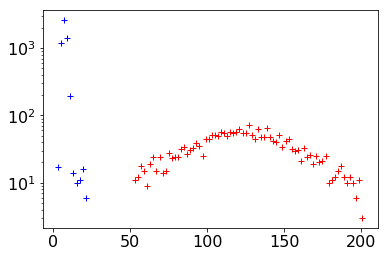

In [85]:
mask = np.where(hist>0)
plt.plot(xbins_center[mask][:10], hist[mask][:10], '+b')
plt.plot(xbins_center[mask][25:100], hist[mask][25:100], '+r')
plt.yscale('log')

In [197]:
popt_init_Noise = [2.76528041e+03, 7.28173379e+00, 6.63997445e-01]
popt_init_SPE = [90.,   0.8, 120.,  30.]
popt_Noise, pcov_Noise = curve_fit(Noise, xbins_center[mask][:10], hist[mask][:10], sigma=np.sqrt(hist[mask][:10]), p0=popt_init_Noise, maxfev=int(1e6))
popt_SPE, pcov_SPE = curve_fit(SPE, xbins_center[mask][25:50], hist[mask][25:50], sigma=np.sqrt(hist[mask][25:50]), p0=popt_init_SPE, maxfev=int(1e6), 
                               bounds=((70,0.5, 100, 20), (150, 1, 130, 40)))
popt_DPE, pcov_DPE = curve_fit(DPE, xbins_center[mask][25:100], hist[mask][25:100], sigma=np.sqrt(hist[mask][25:100]), p0=popt_init_SPE, maxfev=int(1e6),
                               bounds=((70,0.5, 100, 20), (150, 1, 130, 40)))

In [198]:
popt_Noise

array([2.76527739e+03, 7.28173186e+00, 6.63996717e-01])

In [199]:
popt_SPE

array([117.57452351,   0.89355662, 120.8692007 ,  40.        ])

In [200]:
popt_DPE

array([ 70. ,   0.5, 100. ,  40. ])

(1.0, 4000.0)

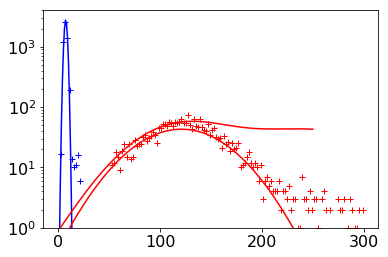

In [201]:
x = np.linspace(0, 250, 250)
plt.plot(x , Noise(x, *popt_Noise), 'b-')
plt.plot(xbins_center[mask][:10], hist[mask][:10], '+b')
plt.plot(x , SPE(x, *popt_SPE), 'r-')
plt.plot(x , DPE(x, *popt_SPE), 'r-')
plt.plot(xbins_center[mask][25:], hist[mask][25:], '+r')
plt.yscale('log')
plt.ylim(1e0, 4e3)

In [120]:
def SPE(x, A1, lamb, mu1, sgm1):
    SPE = A1 * ((lamb**1)*(np.exp(-lamb))/1) * np.exp(-((x-mu1)**2)/(2*(1*sgm1)**2))
    return SPE